# 1. Importar librerías

In [497]:
import pandas as pd
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
from importlib import reload
import utils  # Importa el módulo
reload(utils)  # Recarga el módulo

<module 'utils' from 'c:\\Users\\Usuario\\OneDrive - Universidad de Antioquia\\Documentos\\Universidad\\Analitica2\\Proyecto\\pediccion_abandono_empleo\\utils.py'>

# 2. Importar datos

In [3]:
df_manual = pd.read_csv('Datasets/seleccion_manual.csv')
df_anova = pd.read_csv('Datasets/seleccion_anova.csv')
df_total = pd.read_csv('Datasets/datos_preparados.csv')

#### Separar variable objetivo y hacer el split

In [ ]:
X = df_manual
y = df_total.target

X_train, X_test, y_train, y_test = utils.split(X, y, test_size = 0.2)

# 3. Modelos

## 3.1 Random Forest Classifier

#### Definir grilla

In [66]:
# Definición de cuadricula de hiperparametros
parameters = {'max_depth': [40,50,60,70],
              'max_features': [0.9,1],
              'max_leaf_nodes': [110,120,130],
              'min_samples_leaf': [3,5,7,9],
              'n_estimators': [800]}

#### Realizar la búsqueda

In [67]:
ranfor = RandomForestClassifier(random_state=42, n_jobs=-1, class_weight='balanced')

rand_s = RandomizedSearchCV(estimator = ranfor,
                            param_distributions = parameters,
                            n_iter = 15, scoring = 'f1',
                            cv = 10,
                            verbose = False, n_jobs=-1)
rand_s.fit(X_train, y_train)

RandomizedSearchCV(cv=10,
                   estimator=RandomForestClassifier(class_weight='balanced',
                                                    n_jobs=-1,
                                                    random_state=42),
                   n_iter=15, n_jobs=-1,
                   param_distributions={'max_depth': [40, 50, 60, 70],
                                        'max_features': [0.9, 1],
                                        'max_leaf_nodes': [110, 120, 130],
                                        'min_samples_leaf': [3, 5, 7, 9],
                                        'n_estimators': [800]},
                   scoring='f1', verbose=False)

In [68]:
rand_s.best_estimator_

RandomForestClassifier(class_weight='balanced', max_depth=70, max_features=1,
                       max_leaf_nodes=130, min_samples_leaf=3, n_estimators=800,
                       n_jobs=-1, random_state=42)

#### Instanciar y ajustar modelo con los mejores hiperparámetros encontrados

In [167]:
rf=RandomForestClassifier(class_weight='balanced', max_depth=30, max_features=1,
                       max_leaf_nodes=190, min_samples_leaf=3, n_estimators=1000,
                       n_jobs=-1, random_state=42)
rf.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', max_depth=30, max_features=1,
                       max_leaf_nodes=190, min_samples_leaf=3,
                       n_estimators=1000, n_jobs=-1, random_state=42)

#### Desempeño en train

------------------------------ TRAIN ------------------------------


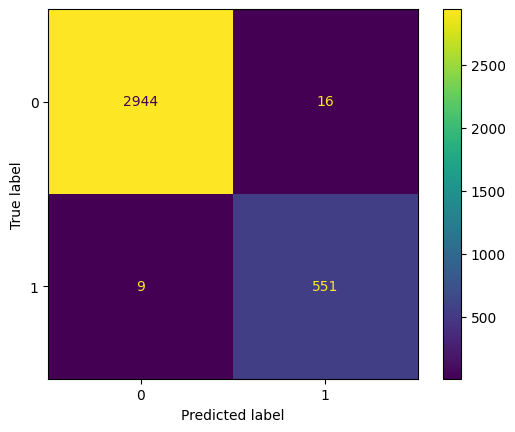

Precision: 0.9717813051146384
Recall: 0.9839285714285714
Especificidad: 0.9945945945945946
F1 score: 0.9778172138420587
Train score:  0.9928977272727273


(0.9717813051146384,
 0.9839285714285714,
 0.9945945945945946,
 0.9778172138420587)

In [500]:
utils.metricas(rf,X_train,y_train,"TRAIN")

#### Desempeño en test

------------------------------ TEST ------------------------------


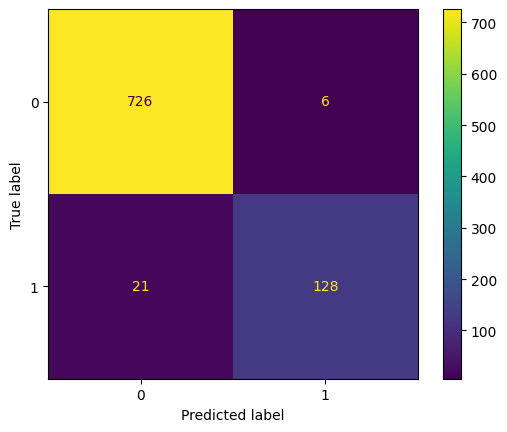

Precision: 0.9552238805970149
Recall: 0.8590604026845637
Especificidad: 0.9918032786885246
F1 score: 0.9045936395759717
Train score:  0.9693530079455165


(0.9552238805970149,
 0.8590604026845637,
 0.9918032786885246,
 0.9045936395759717)

In [508]:
utils.metricas(rf,X_test,y_test,"TEST")

## 3.2. Xtreme Gradiant Boosting

#### Definir grilla

In [263]:
parameters = {'eta': [0.2,0.3,0.4,0.5],
              'colsample_bytree': [0.8,0.9,1],
              'max_depth': [14,16,18,20],
              'n_estimators': [1200,1400,1600],
              'learning_rate':[0.04,0.03,0.05,0.1]
              }

#### Realizar búsqueda

In [269]:
xgb= XGBClassifier(random_state=42, n_jobs=-1)
rand_s = RandomizedSearchCV(estimator=xgb, param_distributions=parameters, n_iter=15, scoring='recall', cv=10, verbose=False)

rand_s.fit(X_train, y_train)


RandomizedSearchCV(cv=10,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, device=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, feature_types=None,
                                           gamma=None, grow_policy=None,
                                           importance_type=None,
                                           interaction_constraints=None,
                                           learning_rat...
                                           min_child_weight=None, missing=nan,
                                           monotone_constraints=None,
                                           multi_strategy=None,
                                           n_estimators=None, n_jobs=-1,
                                           num_parallel_tree=None,
                                           random_state=42, ...),
                   n_iter=15,
                   param_distributions={'colsample_bytree': [0.8, 0.9, 1],
                                        'eta': [0.2, 0.3, 0.4, 0.5],
                                        'learning_rate': [0.04, 0.03, 0.05,
                                                          0.1],
                                        'max_depth': [14, 16, 18, 20],
                                        'n_estimators': [1200, 1400, 1600]},
                   scoring='recall', verbose=False)

In [270]:
rand_s.best_estimator_

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None, colsample_bytree=1,
              device=None, early_stopping_rounds=None, enable_categorical=False,
              eta=0.5, eval_metric=None, feature_types=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.04, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=20, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=1400, n_jobs=-1,
              num_parallel_tree=None, ...)

#### Instanciar y ajustar modelo con mejores hiperparámetros

In [483]:
xgb= XGBClassifier(random_state=42, n_jobs=-1,learning_rate=0.05,max_depth=20,n_estimators=1400,colsample_bytree=0.9)
xgb.fit(X_train,y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.9, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=20, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=1400, n_jobs=-1,
              num_parallel_tree=None, random_state=42, ...)

#### Desempeño en train

------------------------------ TRAIN ------------------------------


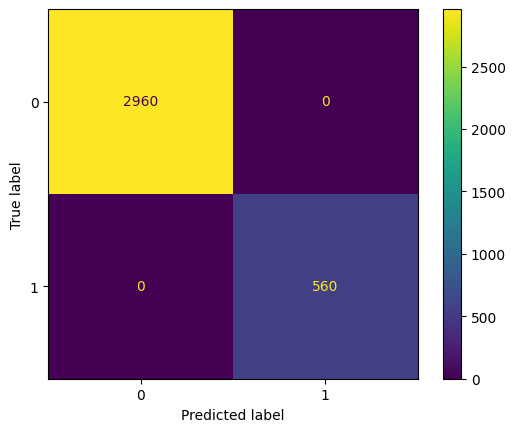

Precision: 1.0
Recall: 1.0
Especificidad: 1.0
F1 score: 1.0
Train score:  1.0


(1.0, 1.0, 1.0, 1.0)

In [502]:
utils.metricas(xgb,X_train,y_train,"TRAIN")

#### Desempeño en test

------------------------------ TEST ------------------------------


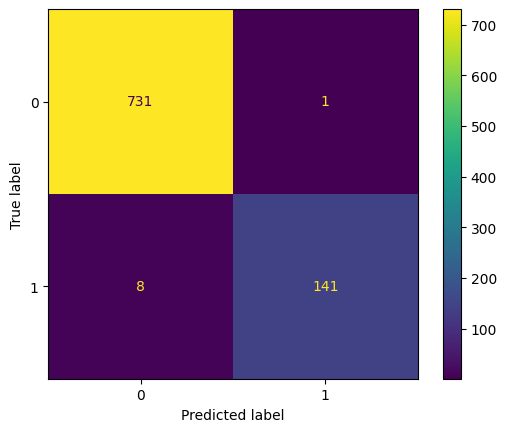

Precision: 0.9929577464788732
Recall: 0.9463087248322147
Especificidad: 0.9986338797814208
F1 score: 0.9690721649484537
Train score:  0.9897843359818388


(0.9929577464788732,
 0.9463087248322147,
 0.9986338797814208,
 0.9690721649484537)

In [507]:
utils.metricas(xgb,X_test,y_test,"TEST")

## 3.3 Support Vector Machine

#### Definir grilla

In [407]:
param_svm = {
    'C': [0.2,0.3,0.4,0.5,1],  # Parámetro de regularización
    'gamma': [0.02,0.01,0.03,0.04]  # Clase de peso balanceado
    }

#### Realizar búsqueda

In [408]:
svm = SVC(random_state = 42, class_weight = 'balanced',max_iter=-1)

rand_s_svm = RandomizedSearchCV(estimator = svm,
                            param_distributions = param_svm,
                            n_iter = 100,
                            scoring = 'f1',
                            cv = 10,
                            verbose = False,
                            n_jobs = -1)
rand_s_svm.fit(X_train, y_train)

c:\Users\Usuario\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_search.py:307: UserWarning: The total space of parameters 20 is smaller than n_iter=100. Running 20 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


RandomizedSearchCV(cv=10,
                   estimator=SVC(class_weight='balanced', random_state=42),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'C': [0.2, 0.3, 0.4, 0.5, 1],
                                        'gamma': [0.02, 0.01, 0.03, 0.04]},
                   scoring='f1', verbose=False)

In [409]:
rand_s_svm.best_estimator_

SVC(C=0.3, class_weight='balanced', gamma=0.04, random_state=42)

#### Instanciar y ajustar modelo con mejores hiperparámetros

In [480]:

svm_ = SVC( class_weight='balanced', gamma=0.05, random_state=42, max_iter=-1)
svm_.fit(X_train,y_train)

SVC(C=1, class_weight='balanced', gamma=0.05, random_state=42)

#### Desempeño en train

------------------------------ TRAIN ------------------------------


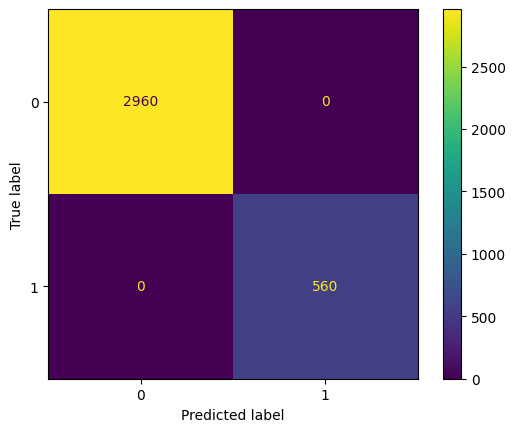

Precision: 1.0
Recall: 1.0
Especificidad: 1.0
F1 score: 1.0
Train score:  1.0


(1.0, 1.0, 1.0, 1.0)

In [504]:
utils.metricas(svm_,X_train,y_train,"TRAIN")

#### Desempeño en test

------------------------------ TEST ------------------------------


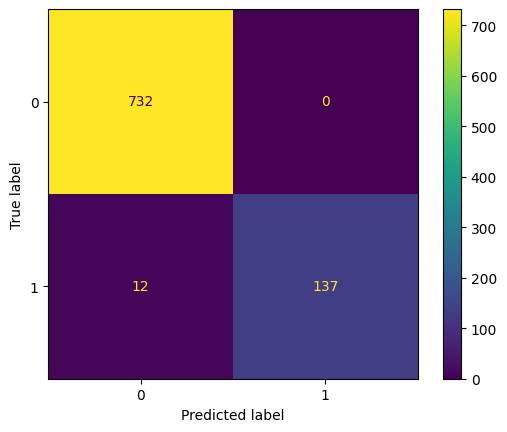

Precision: 1.0
Recall: 0.9194630872483222
Especificidad: 1.0
F1 score: 0.958041958041958
Train score:  0.9863791146424518


(1.0, 0.9194630872483222, 1.0, 0.958041958041958)

In [506]:
utils.metricas(svm_,X_test,y_test,"TEST")